# Correlations and Chi squared

This script finds the correlations between numerical features of the EPC data and performs a chi-squared test on all EPC variables

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import glob
import json
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set variables from config file
config_path = os.path.abspath('..')[:-7]

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
epc_train_fname = config['DEFAULT']['epc_train_fname']
epc_test_fname = config['DEFAULT']['epc_test_fname']

In [3]:
dtype_dict = {'INSPECTION_DATE':'str'}

epc_train = pd.read_csv(os.path.join(processing_path,epc_train_fname),
                        header = 0,
                        delimiter = ',',
                        dtype = dtype_dict,
                        parse_dates = ['INSPECTION_DATE'])

epc_test = pd.read_csv(os.path.join(processing_path,epc_test_fname),
                        header = 0,
                        delimiter = ',',
                        dtype = dtype_dict,
                        parse_dates = ['INSPECTION_DATE'])

In [4]:
#Numeric
var_list_num = epc_train.select_dtypes(include= 'number').columns.tolist()
var_list_num.remove('BUILDING_REFERENCE_NUMBER')

#Categorical
var_list_cat = epc_train.select_dtypes(include= ['object','category']).columns.tolist()
var_list_cat.remove('LMK_KEY')
var_list_cat.remove('POSTCODE')
var_list_cat.remove('CURRENT_ENERGY_RATING')

### Numeric features correrlations against the other fields in the taxonomy  

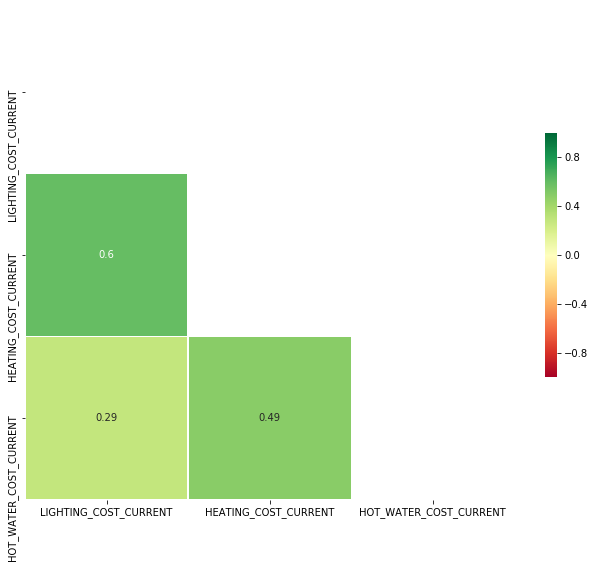

In [5]:
corr_energy_costs = epc_train[['LIGHTING_COST_CURRENT',
                               'HEATING_COST_CURRENT',
                               'HOT_WATER_COST_CURRENT']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_energy_costs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_energy_costs, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

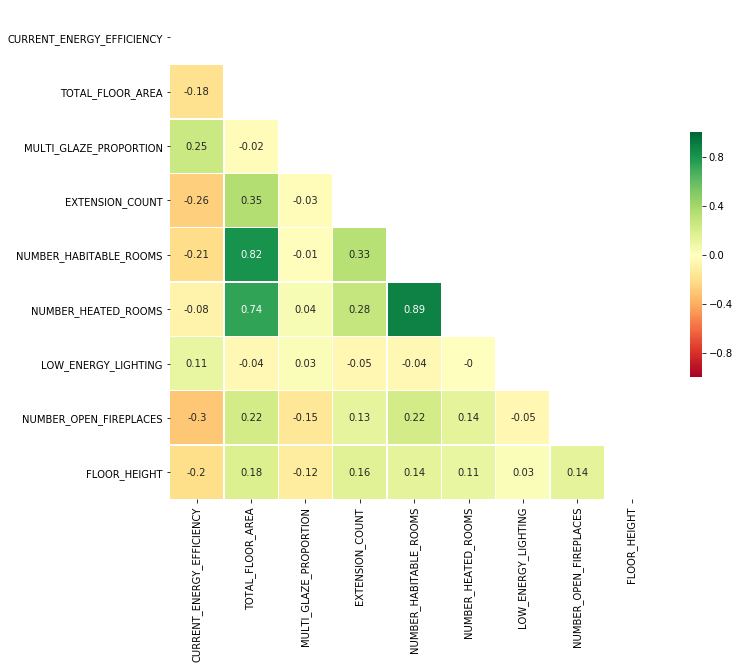

In [7]:
#House descriptions
corr_house_desc = epc_train[[ 'CURRENT_ENERGY_EFFICIENCY',
                            'TOTAL_FLOOR_AREA',
                            'MULTI_GLAZE_PROPORTION',
                            'EXTENSION_COUNT',
                            'NUMBER_HABITABLE_ROOMS',
                            'NUMBER_HEATED_ROOMS',
                            'LOW_ENERGY_LIGHTING',
                            'NUMBER_OPEN_FIREPLACES',
                            'FLOOR_HEIGHT']].corr()
# plot correlations
corr_house_desc = round(corr_house_desc,2)
mask = np.zeros_like(corr_house_desc, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_house_desc, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

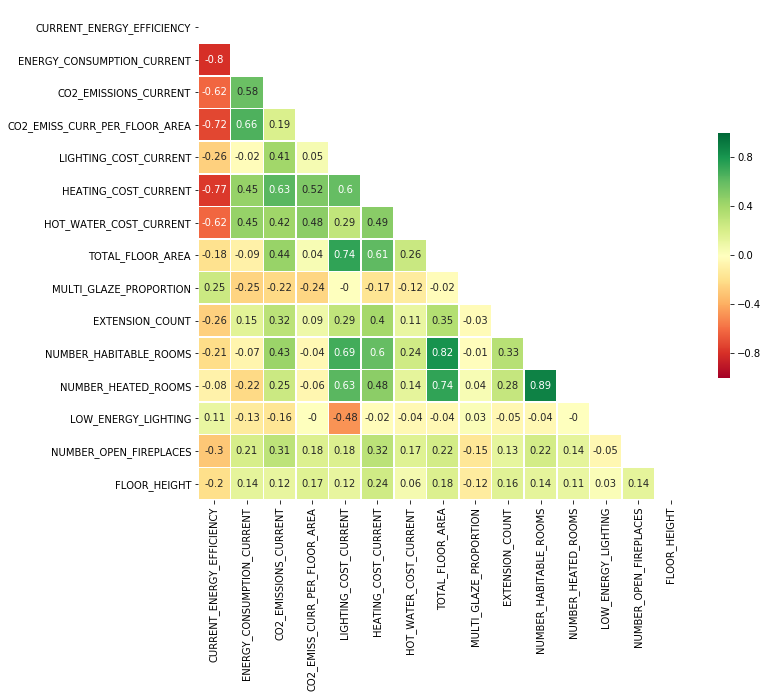

In [8]:
corr_all = epc_train[var_list_num].corr()

# plot correlations
corr_all = round(corr_all,2)
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_all, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

### Categorical features Chi-Squared test of independence between variables in taxonomy
if Chi-squared > crit_value reject the null hypothesis that there is no relationship between both variables        Uplift is a measure of the uplift between the chi squared metric and the critical value (I am assuming that the larger the uplift. The stronger the relastionship between the features (I am not 100% about this so I am checking with Gareth)

In [13]:
#Function to run a series of chi-squared independance tests for all the
#possible combinations of a variable within a dataframe

def get_chi_squared_all(df):
    
    ''' 
    Performs a chi-squared test between all variables in the dataframe
    Parameters
      df: a dataframe
    Returns a dataframe
    '''
    
    results_buffer = {}
    for var1 in df.columns.values:
        for var2 in df.columns.values:
            if(var1 != var2):
                xtab = pd.crosstab(df[var1],df[var2])
                res = stats.chi2_contingency(xtab)
                chi_squred_crit_value = stats.chi2.ppf(q = 0.95,df = res[2])
                #TODO I don't think printing all this is helpful, it's too fast to see
                print("\nResults for %s and %s" % (var1, var2))
                print("\tChi-squared:\t%f" % res[0])
                print("\tP-value:\t%f" % res[1])
                print("\tDoF:\t\t%i" % res[2])
                print("\tCrit-value:\t%f" % chi_squred_crit_value)
                print("\tUplift:\t\t%f" % (res[0] / chi_squred_crit_value))
                results_buffer[(var1, var2)] = (res[0] / chi_squred_crit_value)
    return pd.Series(results_buffer, name = 'uplift').sort_values(ascending = False)

chi2_all = get_chi_squared_all(epc_train[var_list_cat])


Results for region and PROPERTY_TYPE
	Chi-squared:	62033.940967
	P-value:	0.000000
	DoF:		84
	Crit-value:	106.394840
	Uplift:		583.054036

Results for region and BUILT_FORM
	Chi-squared:	60710.690702
	P-value:	0.000000
	DoF:		105
	Crit-value:	129.917955
	Uplift:		467.300232

Results for region and TRANSACTION_TYPE
	Chi-squared:	50396.060199
	P-value:	0.000000
	DoF:		273
	Crit-value:	312.537713
	Uplift:		161.247933

Results for region and ENERGY_TARIFF
	Chi-squared:	26663.324164
	P-value:	0.000000
	DoF:		147
	Crit-value:	176.293823
	Uplift:		151.243667

Results for region and MAINS_GAS_FLAG
	Chi-squared:	116174.867043
	P-value:	0.000000
	DoF:		21
	Crit-value:	32.670573
	Uplift:		3555.948218

Results for region and FLOOR_LEVEL
	Chi-squared:	29898.184218
	P-value:	0.000000
	DoF:		525
	Crit-value:	579.411929
	Uplift:		51.600912

Results for region and MAIN_HEATING_CONTROLS
	Chi-squared:	114379.315241
	P-value:	0.000000
	DoF:		1848
	Crit-value:	1949.122496
	Uplift:		58.682466

Results for 


Results for PROPERTY_TYPE and MAINHEATC_ENERGY_EFF
	Chi-squared:	9839.737916
	P-value:	0.000000
	DoF:		16
	Crit-value:	26.296228
	Uplift:		374.188194

Results for PROPERTY_TYPE and MAINHEATC_ENV_EFF
	Chi-squared:	9839.737916
	P-value:	0.000000
	DoF:		16
	Crit-value:	26.296228
	Uplift:		374.188194

Results for PROPERTY_TYPE and LIGHTING_DESCRIPTION
	Chi-squared:	37512.524023
	P-value:	0.000000
	DoF:		1108
	Crit-value:	1186.550760
	Uplift:		31.614765

Results for PROPERTY_TYPE and LIGHTING_ENERGY_EFF
	Chi-squared:	3370.419126
	P-value:	0.000000
	DoF:		16
	Crit-value:	26.296228
	Uplift:		128.171203

Results for PROPERTY_TYPE and LIGHTING_ENV_EFF
	Chi-squared:	3329.158636
	P-value:	0.000000
	DoF:		16
	Crit-value:	26.296228
	Uplift:		126.602138

Results for PROPERTY_TYPE and MAIN_FUEL
	Chi-squared:	104456.869219
	P-value:	0.000000
	DoF:		144
	Crit-value:	173.004059
	Uplift:		603.782765

Results for PROPERTY_TYPE and HEAT_LOSS_CORRIDOOR
	Chi-squared:	7989.224707
	P-value:	0.000000
	DoF:		6



Results for TRANSACTION_TYPE and WALLS_DESCRIPTION
	Chi-squared:	956392.442290
	P-value:	0.000000
	DoF:		7956
	Crit-value:	8164.617195
	Uplift:		117.138675

Results for TRANSACTION_TYPE and WALLS_ENERGY_EFF
	Chi-squared:	438365.773053
	P-value:	0.000000
	DoF:		52
	Crit-value:	69.832160
	Uplift:		6277.419615

Results for TRANSACTION_TYPE and WALLS_ENV_EFF
	Chi-squared:	438365.773053
	P-value:	0.000000
	DoF:		52
	Crit-value:	69.832160
	Uplift:		6277.419615

Results for TRANSACTION_TYPE and SECONDHEAT_DESCRIPTION
	Chi-squared:	86039.229751
	P-value:	0.000000
	DoF:		702
	Crit-value:	764.748557
	Uplift:		112.506560

Results for TRANSACTION_TYPE and ROOF_DESCRIPTION
	Chi-squared:	751177.925274
	P-value:	0.000000
	DoF:		4693
	Crit-value:	4853.484576
	Uplift:		154.770848

Results for TRANSACTION_TYPE and ROOF_ENERGY_EFF
	Chi-squared:	128205.507617
	P-value:	0.000000
	DoF:		52
	Crit-value:	69.832160
	Uplift:		1835.909229

Results for TRANSACTION_TYPE and ROOF_ENV_EFF
	Chi-squared:	128205.50761


Results for MAINS_GAS_FLAG and ENERGY_TARIFF
	Chi-squared:	95762.596111
	P-value:	0.000000
	DoF:		7
	Crit-value:	14.067140
	Uplift:		6807.538210

Results for MAINS_GAS_FLAG and FLOOR_LEVEL
	Chi-squared:	5552.303271
	P-value:	0.000000
	DoF:		25
	Crit-value:	37.652484
	Uplift:		147.461805

Results for MAINS_GAS_FLAG and MAIN_HEATING_CONTROLS
	Chi-squared:	162953.218628
	P-value:	0.000000
	DoF:		69
	Crit-value:	89.391208
	Uplift:		1822.922215

Results for MAINS_GAS_FLAG and GLAZED_TYPE
	Chi-squared:	3419.224421
	P-value:	0.000000
	DoF:		8
	Crit-value:	15.507313
	Uplift:		220.491094

Results for MAINS_GAS_FLAG and HOTWATER_DESCRIPTION
	Chi-squared:	160522.586458
	P-value:	0.000000
	DoF:		111
	Crit-value:	136.591071
	Uplift:		1175.205561

Results for MAINS_GAS_FLAG and HOT_WATER_ENERGY_EFF
	Chi-squared:	182770.844037
	P-value:	0.000000
	DoF:		4
	Crit-value:	9.487729
	Uplift:		19263.919040

Results for MAINS_GAS_FLAG and HOT_WATER_ENV_EFF
	Chi-squared:	205776.995138
	P-value:	0.000000
	DoF:


Results for FLOOR_LEVEL and LIGHTING_DESCRIPTION
	Chi-squared:	40117.982553
	P-value:	0.000000
	DoF:		3675
	Crit-value:	3817.144664
	Uplift:		10.509946

Results for FLOOR_LEVEL and LIGHTING_ENERGY_EFF
	Chi-squared:	9635.387477
	P-value:	0.000000
	DoF:		100
	Crit-value:	124.342113
	Uplift:		77.490942

Results for FLOOR_LEVEL and LIGHTING_ENV_EFF
	Chi-squared:	9645.103582
	P-value:	0.000000
	DoF:		100
	Crit-value:	124.342113
	Uplift:		77.569082

Results for FLOOR_LEVEL and MAIN_FUEL
	Chi-squared:	65931.442039
	P-value:	0.000000
	DoF:		750
	Crit-value:	814.821511
	Uplift:		80.915196

Results for FLOOR_LEVEL and HEAT_LOSS_CORRIDOOR
	Chi-squared:	8910.358759
	P-value:	0.000000
	DoF:		44
	Crit-value:	60.480887
	Uplift:		147.325201

Results for FLOOR_LEVEL and MECHANICAL_VENTILATION
	Chi-squared:	258.234252
	P-value:	0.000000
	DoF:		44
	Crit-value:	60.480887
	Uplift:		4.269684

Results for MAIN_HEATING_CONTROLS and region
	Chi-squared:	114379.315241
	P-value:	0.000000
	DoF:		1848
	Crit-value


Results for GLAZED_TYPE and WINDOWS_ENV_EFF
	Chi-squared:	1153680.647795
	P-value:	0.000000
	DoF:		32
	Crit-value:	46.194260
	Uplift:		24974.545750

Results for GLAZED_TYPE and WALLS_DESCRIPTION
	Chi-squared:	88671.817768
	P-value:	0.000000
	DoF:		2136
	Crit-value:	2244.633483
	Uplift:		39.503918

Results for GLAZED_TYPE and WALLS_ENERGY_EFF
	Chi-squared:	18588.897658
	P-value:	0.000000
	DoF:		32
	Crit-value:	46.194260
	Uplift:		402.407092

Results for GLAZED_TYPE and WALLS_ENV_EFF
	Chi-squared:	18588.897658
	P-value:	0.000000
	DoF:		32
	Crit-value:	46.194260
	Uplift:		402.407092

Results for GLAZED_TYPE and SECONDHEAT_DESCRIPTION
	Chi-squared:	113972.562012
	P-value:	0.000000
	DoF:		1056
	Crit-value:	1132.711554
	Uplift:		100.619228

Results for GLAZED_TYPE and ROOF_DESCRIPTION
	Chi-squared:	88983.777478
	P-value:	0.000000
	DoF:		3624
	Crit-value:	3765.162697
	Uplift:		23.633448

Results for GLAZED_TYPE and ROOF_ENERGY_EFF
	Chi-squared:	11916.417554
	P-value:	0.000000
	DoF:		32
	Crit


Results for HOT_WATER_ENERGY_EFF and BUILT_FORM
	Chi-squared:	11796.842031
	P-value:	0.000000
	DoF:		20
	Crit-value:	31.410433
	Uplift:		375.570820

Results for HOT_WATER_ENERGY_EFF and TRANSACTION_TYPE
	Chi-squared:	48466.296549
	P-value:	0.000000
	DoF:		52
	Crit-value:	69.832160
	Uplift:		694.039771

Results for HOT_WATER_ENERGY_EFF and ENERGY_TARIFF
	Chi-squared:	79415.789747
	P-value:	0.000000
	DoF:		28
	Crit-value:	41.337138
	Uplift:		1921.172904

Results for HOT_WATER_ENERGY_EFF and MAINS_GAS_FLAG
	Chi-squared:	182770.844037
	P-value:	0.000000
	DoF:		4
	Crit-value:	9.487729
	Uplift:		19263.919040

Results for HOT_WATER_ENERGY_EFF and FLOOR_LEVEL
	Chi-squared:	9095.161965
	P-value:	0.000000
	DoF:		100
	Crit-value:	124.342113
	Uplift:		73.146271

Results for HOT_WATER_ENERGY_EFF and MAIN_HEATING_CONTROLS
	Chi-squared:	336524.989777
	P-value:	0.000000
	DoF:		348
	Crit-value:	392.501156
	Uplift:		857.385984

Results for HOT_WATER_ENERGY_EFF and GLAZED_TYPE
	Chi-squared:	6832.170469



Results for HOT_WATER_ENV_EFF and MAINHEAT_ENV_EFF
	Chi-squared:	1077064.815905
	P-value:	0.000000
	DoF:		16
	Crit-value:	26.296228
	Uplift:		40958.909852

Results for HOT_WATER_ENV_EFF and MAINHEATCONT_DESCRIPTION
	Chi-squared:	350011.939007
	P-value:	0.000000
	DoF:		352
	Crit-value:	396.750009
	Uplift:		882.197685

Results for HOT_WATER_ENV_EFF and MAINHEATC_ENERGY_EFF
	Chi-squared:	63712.933218
	P-value:	0.000000
	DoF:		16
	Crit-value:	26.296228
	Uplift:		2422.892522

Results for HOT_WATER_ENV_EFF and MAINHEATC_ENV_EFF
	Chi-squared:	63712.933218
	P-value:	0.000000
	DoF:		16
	Crit-value:	26.296228
	Uplift:		2422.892522

Results for HOT_WATER_ENV_EFF and LIGHTING_DESCRIPTION
	Chi-squared:	18494.941434
	P-value:	0.000000
	DoF:		1024
	Crit-value:	1099.557146
	Uplift:		16.820355

Results for HOT_WATER_ENV_EFF and LIGHTING_ENERGY_EFF
	Chi-squared:	3106.050868
	P-value:	0.000000
	DoF:		16
	Crit-value:	26.296228
	Uplift:		118.117736

Results for HOT_WATER_ENV_EFF and LIGHTING_ENV_EFF
	Chi-


Results for WINDOWS_DESCRIPTION and HOT_WATER_ENERGY_EFF
	Chi-squared:	28782.773435
	P-value:	0.000000
	DoF:		188
	Crit-value:	220.990822
	Uplift:		130.244203

Results for WINDOWS_DESCRIPTION and HOT_WATER_ENV_EFF
	Chi-squared:	26104.963710
	P-value:	0.000000
	DoF:		188
	Crit-value:	220.990822
	Uplift:		118.126914

Results for WINDOWS_DESCRIPTION and FLOOR_DESCRIPTION
	Chi-squared:	2493101.067528
	P-value:	0.000000
	DoF:		20022
	Crit-value:	20352.284710
	Uplift:		122.497356

Results for WINDOWS_DESCRIPTION and WINDOWS_ENERGY_EFF
	Chi-squared:	1520337.460079
	P-value:	0.000000
	DoF:		188
	Crit-value:	220.990822
	Uplift:		6879.640743

Results for WINDOWS_DESCRIPTION and WINDOWS_ENV_EFF
	Chi-squared:	1520337.460079
	P-value:	0.000000
	DoF:		188
	Crit-value:	220.990822
	Uplift:		6879.640743

Results for WINDOWS_DESCRIPTION and WALLS_DESCRIPTION
	Chi-squared:	2743920.349368
	P-value:	0.000000
	DoF:		39292
	Crit-value:	39754.233377
	Uplift:		69.022092

Results for WINDOWS_DESCRIPTION and WA


Results for WINDOWS_ENERGY_EFF and HEAT_LOSS_CORRIDOOR
	Chi-squared:	2250.960345
	P-value:	0.000000
	DoF:		8
	Crit-value:	15.507313
	Uplift:		145.154763

Results for WINDOWS_ENERGY_EFF and MECHANICAL_VENTILATION
	Chi-squared:	1042.705757
	P-value:	0.000000
	DoF:		8
	Crit-value:	15.507313
	Uplift:		67.239615

Results for WINDOWS_ENV_EFF and region
	Chi-squared:	27265.181448
	P-value:	0.000000
	DoF:		84
	Crit-value:	106.394840
	Uplift:		256.264133

Results for WINDOWS_ENV_EFF and PROPERTY_TYPE
	Chi-squared:	11257.652011
	P-value:	0.000000
	DoF:		16
	Crit-value:	26.296228
	Uplift:		428.109012

Results for WINDOWS_ENV_EFF and BUILT_FORM
	Chi-squared:	9433.243075
	P-value:	0.000000
	DoF:		20
	Crit-value:	31.410433
	Uplift:		300.321970

Results for WINDOWS_ENV_EFF and TRANSACTION_TYPE
	Chi-squared:	399873.197711
	P-value:	0.000000
	DoF:		52
	Crit-value:	69.832160
	Uplift:		5726.204026

Results for WINDOWS_ENV_EFF and ENERGY_TARIFF
	Chi-squared:	389283.816505
	P-value:	0.000000
	DoF:		28
	Cr


Results for WALLS_DESCRIPTION and ROOF_DESCRIPTION
	Chi-squared:	74726256.153924
	P-value:	0.000000
	DoF:		601084
	Crit-value:	602888.610117
	Uplift:		123.947036

Results for WALLS_DESCRIPTION and ROOF_ENERGY_EFF
	Chi-squared:	217805.294582
	P-value:	0.000000
	DoF:		2732
	Crit-value:	2854.712095
	Uplift:		76.296764

Results for WALLS_DESCRIPTION and ROOF_ENV_EFF
	Chi-squared:	217805.294582
	P-value:	0.000000
	DoF:		2732
	Crit-value:	2854.712095
	Uplift:		76.296764

Results for WALLS_DESCRIPTION and MAINHEAT_ENERGY_EFF
	Chi-squared:	121125.615924
	P-value:	0.000000
	DoF:		3140
	Crit-value:	3271.475899
	Uplift:		37.024762

Results for WALLS_DESCRIPTION and MAINHEAT_ENV_EFF
	Chi-squared:	127107.953136
	P-value:	0.000000
	DoF:		3052
	Crit-value:	3181.636232
	Uplift:		39.950498

Results for WALLS_DESCRIPTION and MAINHEATCONT_DESCRIPTION
	Chi-squared:	6612841.693811
	P-value:	0.000000
	DoF:		70224
	Crit-value:	70841.566735
	Uplift:		93.346915

Results for WALLS_DESCRIPTION and MAINHEATC_ENE


Results for WALLS_ENV_EFF and GLAZED_TYPE
	Chi-squared:	18588.897658
	P-value:	0.000000
	DoF:		32
	Crit-value:	46.194260
	Uplift:		402.407092

Results for WALLS_ENV_EFF and HOTWATER_DESCRIPTION
	Chi-squared:	53787.608637
	P-value:	0.000000
	DoF:		496
	Crit-value:	548.918230
	Uplift:		97.988381

Results for WALLS_ENV_EFF and HOT_WATER_ENERGY_EFF
	Chi-squared:	26680.353653
	P-value:	0.000000
	DoF:		16
	Crit-value:	26.296228
	Uplift:		1014.607648

Results for WALLS_ENV_EFF and HOT_WATER_ENV_EFF
	Chi-squared:	24304.294189
	P-value:	0.000000
	DoF:		16
	Crit-value:	26.296228
	Uplift:		924.250222

Results for WALLS_ENV_EFF and FLOOR_DESCRIPTION
	Chi-squared:	454832.775733
	P-value:	0.000000
	DoF:		1684
	Crit-value:	1780.581646
	Uplift:		255.440562

Results for WALLS_ENV_EFF and WINDOWS_DESCRIPTION
	Chi-squared:	345425.031267
	P-value:	0.000000
	DoF:		188
	Crit-value:	220.990822
	Uplift:		1563.074108

Results for WALLS_ENV_EFF and WINDOWS_ENERGY_EFF
	Chi-squared:	370061.256767
	P-value:	0.000

KeyboardInterrupt: 

In [ ]:
#Function to run a series of chi-squared independance tests for all the
#features against the target
def get_chi_squared_target(df,target,feature_list):
    
    ''' 
    Performs a chi-squared test between specified variables in the dataframe
    Parameters
      df: a dataframe
      target: string, a variable you want to be in every chi-squared
      feature_list: list, the other variables you want to test the target with
    Returns a dataframe
    '''
    
    results_buffer = {}
    for var in feature_list:
        xtab = pd.crosstab(df[target],df[var])
        res = stats.chi2_contingency(xtab)
        chi_squred_crit_value = stats.chi2.ppf(q = 0.95,df = res[2])
        print("\nResults for %s and %s" % (target, var))
        print("\tChi-squared:\t%f" % res[0])
        print("\tP-value:\t%f" % res[1])
        print("\tDoF:\t\t%i" % res[2])
        print("\tCrit-value:\t%f" % chi_squred_crit_value)
        print("\tUplift:\t\t%f" % (res[0] / chi_squred_crit_value))
        results_buffer[var] = (res[0] / chi_squred_crit_value)
    return pd.Series(results_buffer, name = 'uplift').sort_values(ascending = False)


chi2_target = get_chi_squared_target(epc_train,'CURRENT_ENERGY_RATING',var_list_cat)
